# Comparing streaming vs rest from 10/05 to 16/05

## Load and tidy data

In [2]:
import tweepy
import sys
import json
import time
import pandas as pd
import requests
from requests_oauthlib import OAuth1
import datetime as dt
import importlib
import matplotlib.pyplot as plt

import process_tweets
import get_rest_tweets

In [3]:
users = pd.read_csv('data/seed_users.csv').screen_name.values

In [4]:
stream_list = []
for i in range(10,17):
    with open('data/raw/seed_tweets/stream_tweets_2005%i.json'%i) as json_data:
        stream = json_data.readlines()
        stream = process_tweets.tidy_tweets(stream)
        stream_list.append(stream)
        
stream = pd.concat(stream_list).reset_index(drop=True)

In [5]:
rest_list = []
for i in range(10,17):
    with open('data/raw/seed_tweets/rest_tweets_2005%i.json'%i) as json_data:
        rest = json_data.readlines()
        rest = process_tweets.tidy_tweets(rest)
        rest_list.append(rest)
        
rest = pd.concat(rest_list).reset_index(drop=True).drop_duplicates("id")
rest.datetime = pd.to_datetime(rest.datetime)

In [6]:
for df in [stream,rest]:
    df['seed_mentions']=df.mentions.apply(lambda x: [u for u in users if u in x])
    df['seed_mentions']=df['seed_mentions'].apply(lambda x: x[0] if len(x)>0 else "")
    df['seed_qt_mentions'] = df.qt_status.apply(lambda x: "-" if x is None else x)
    df['seed_qt_mentions'] = df['seed_qt_mentions'].apply(lambda x: [u for u in users if u in x])
    df['seed_qt_mentions'] = df['seed_qt_mentions'].apply(lambda x: x[0] if len(x) > 0 else "")

    df.loc[(df['rt_from_screen_name'].isna()) & (df['qt_from_screen_name'].notna()), 'direct_qt'] = df['qt_from_screen_name']
    df.loc[(df['rt_from_screen_name'].notna()) & (df['qt_from_screen_name'].notna()), 'rt_qt'] = df['qt_from_screen_name']
    df.loc[~(df['rt_from_screen_name'].isin(users)) & ~(df['qt_from_screen_name'].isin(users)) & ~(df['in_reply_to_screen_name'].isin(users)), 'direct_mentions'] = df['seed_mentions']
    df.loc[~(df['rt_from_screen_name'].isin(users)) & ~(df['qt_from_screen_name'].isin(users)) & ~(df['in_reply_to_screen_name'].isin(users)) & ~(df['direct_mentions'].isin(users)), 'direct_qt_mentions'] = df['seed_qt_mentions']

In [7]:
print(len(stream), len(rest))

3820 3055


## ~15% missing tweets all retweets
- Conection wasn't interrupted
- Tried streaming both with tweepy and with direct requests, same results

In [8]:
# Number of tweets not captured by stream
print(len(rest[~rest.id.isin(stream.id)]), len(stream), len(rest[~rest.id.isin(stream.id)])/len(stream))

564 3820 0.14764397905759163


In [9]:
missing_tweets = rest[~rest.id.isin(stream.id)].reset_index(drop=True)
missing_tweets['missing'] = "missing"

In [10]:
missing_count = missing_tweets[['screen_name','rt_from_screen_name','rt_qt','direct_qt','in_reply_to_screen_name','direct_mentions']]\
                .apply(pd.Series.value_counts)\
                .loc[['OhBrokenBritain','TradBritGroup','NeilUKIP']]
missing_pct = missing_count.div(missing_count.sum(axis=1), axis=0)


In [11]:
missing_count

,screen_name,rt_from_screen_name,rt_qt,direct_qt,in_reply_to_screen_name,direct_mentions
OhBrokenBritain,NaN,424.0,NaN,NaN,NaN,NaN
TradBritGroup,NaN,16.0,NaN,NaN,NaN,NaN
NeilUKIP,NaN,124.0,NaN,NaN,NaN,NaN


In [13]:
stream_count = stream[['screen_name','rt_from_screen_name','rt_qt','direct_qt','in_reply_to_screen_name','direct_mentions']]\
                .apply(pd.Series.value_counts)\
                .loc[['OhBrokenBritain','TradBritGroup','NeilUKIP']]

In [14]:
stream_count

,screen_name,rt_from_screen_name,rt_qt,direct_qt,in_reply_to_screen_name,direct_mentions
OhBrokenBritain,76.0,1313.0,25.0,7.0,289.0,262.0
TradBritGroup,94.0,417.0,73.0,25.0,119.0,84.0
NeilUKIP,24.0,423.0,77.0,28.0,116.0,315.0


In [15]:
print("Total tweets collected: ",len(missing_tweets))
print("tweets by seed users: ",len(missing_tweets[missing_tweets.screen_name.isin(users)]))
print("Self retweets: ",len(missing_tweets[(missing_tweets.rt_from_screen_name.isin(users))&(missing_tweets.screen_name.isin(users))]))
print("Retweets: ",len(missing_tweets[(missing_tweets.rt_from_screen_name.isin(users))&~(missing_tweets.screen_name.isin(users))]))
print("Retweeted quotes: ",len(missing_tweets[(missing_tweets.qt_from_screen_name.isin(users)) & missing_tweets.rt_from_screen_name.notna()]))
print("Direct quotes: ",len(missing_tweets[(missing_tweets.qt_from_screen_name.isin(users)) & missing_tweets.rt_from_screen_name.isna()]))
print("Replies: ",len(missing_tweets[(missing_tweets.in_reply_to_screen_name.isin(users)) & (missing_tweets.rt_from_screen_name.isna())]))
print("Direct mentions: ", len(missing_tweets[(missing_tweets.direct_mentions.isin(users))]))
print("Direct qt mentions: ", len(missing_tweets[(missing_tweets.direct_qt_mentions.isin(users))]))

Total tweets collected:  564
tweets by seed users:  0
Self retweets:  0
Retweets:  564
Retweeted quotes:  0
Direct quotes:  0
Replies:  0
Direct mentions:  0
Direct qt mentions:  0


In [16]:
print("Total tweets collected: ",len(stream))
print("tweets by seed users: ",len(stream[stream.screen_name.isin(users)]))
print("Self retweets: ",len(stream[(stream.rt_from_screen_name.isin(users))&(stream.screen_name.isin(users))]))
print("Retweets: ",len(stream[(stream.rt_from_screen_name.isin(users))&~(stream.screen_name.isin(users))]))
print("Retweeted quotes: ",len(stream[(stream.qt_from_screen_name.isin(users)) & stream.rt_from_screen_name.notna()]))
print("Direct quotes: ",len(stream[(stream.qt_from_screen_name.isin(users)) & stream.rt_from_screen_name.isna()]))
print("Replies: ",len(stream[(stream.in_reply_to_screen_name.isin(users)) & (stream.rt_from_screen_name.isna())]))
print("Direct mentions: ", len(stream[(stream.direct_mentions.isin(users))]))
print("Direct qt mentions: ", len(stream[(stream.direct_qt_mentions.isin(users))]))

Total tweets collected:  3820
tweets by seed users:  194
Self retweets:  23
Retweets:  2130
Retweeted quotes:  175
Direct quotes:  60
Replies:  524
Direct mentions:  661
Direct qt mentions:  29


## Up to 24% missing retweets

In [18]:
# Percent of each category that we are missing
missing_count.fillna(0).div(missing_count.fillna(0) + stream_count)

,screen_name,rt_from_screen_name,rt_qt,direct_qt,in_reply_to_screen_name,direct_mentions
OhBrokenBritain,0.0,0.244099,0.0,0.0,0.0,0.0
TradBritGroup,0.0,0.036952,0.0,0.0,0.0,0.0
NeilUKIP,0.0,0.226691,0.0,0.0,0.0,0.0


In [19]:
total_tweets = pd.concat([stream,missing_tweets]).reset_index(drop=True)
total_tweets['missing'] = total_tweets['missing'].fillna('collected')
total_tweets['day'] = pd.DatetimeIndex(total_tweets['datetime']).day
total_tweets['hour'] = pd.DatetimeIndex(total_tweets['datetime']).hour

## Doesn't seem to respond to particular days/times, neither to specific users or tweets

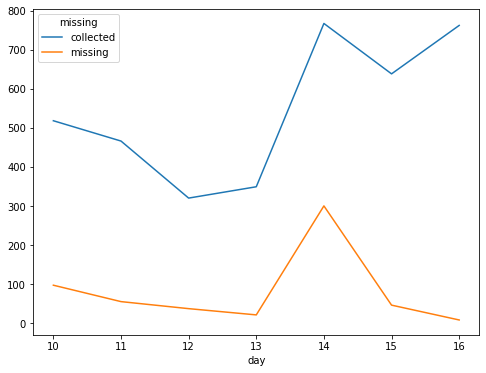

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
total_tweets.groupby(['day','missing']).count()['id'].unstack().plot(ax=ax)

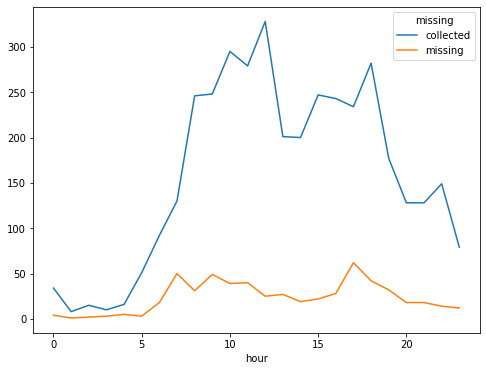

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
total_tweets.groupby(['hour','missing']).count()['id'].unstack().plot(ax=ax)